In [1044]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin

class Palanthir(object):
## Native attributes
    def __init__(self, input, target_feature:str=None, init_test_size:(float,None)=None):
        """Initiates a Palanthir-class on-top a Pandas Dataframe. The class-attributes describes the overall structure and composition of the data"""
        self.input_data = input
        ##When the Palanthir is born with a target variable:
        if isinstance(target_feature,str):
        #...AND is to be split into test-train subsets
            self.Y_col = [target_feature]
            self.X_cols = [col for col in self.input_data.columns if col not in self.Y_col]
            if isinstance(init_test_size,float):
                self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.input_data[self.X_cols],self.input_data[self.Y_col],test_size=0.2,random_state=42)
                self.output = self.train_X.copy(deep=True)
        #...BUT IS NOT to be split into test-train subsets
            else:
                self.Y = self.input_data.copy(deep=True)[self.Y_col]
                self.X = self.input_data.copy(deep=True)[self.X_cols]
                self.output = self.X.copy(deep=True)
        ##When the Palanthir is NOT born with a target variable:
        else:
        # ...BUT IS to be split into test-train subsets
            if isinstance(init_test_size,float):
                self.train, self.test = train_test_split(self.input_data,test_size=0.2,random_state=42)
                self.output = self.train.copy(deep=True)
        #...AND IS NOT to be split into test-train subsets.
            else:
                self.output = self.input_data.copy(deep=True)
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])
        self.current_version = 0
        self.transformation_history = [dict(version=0,transformation='input',result=self.input_data,pipeline=ColumnTransformer([]))]

## Self-update and audit commands

    def update_attributes(self):
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])

    def update_history(self, step=None, snapshot=None,text=None,transformer=None,cols=None):
        pipelineSteps = self.transformation_history[-1].get('pipeline').get_params().get('transformers') + [(text,transformer,cols)]
        updatedPipeline = ColumnTransformer(pipelineSteps)
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=updatedPipeline
            )
        )

    def restore(self, version=None):
        versionCheckpoint = (self.current_version - 1) if version == None else version
        self.current_version = versionCheckpoint
        self.output = self.transformation_history[versionCheckpoint].get('result')
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Restored to version {self.current_version}"
                ,result=self.transformation_history[self.current_version].get('result')
                ,pipeline=self.transformation_history[self.current_version].get('pipeline')
            )
        )
        return self.transformation_history[self.current_version].get('pipeline')

    ##NOTE: DEEPCOPY - Perhaps it makes sense changing the self.output to a dynamic version of train_x. Likewise for the X and Y
    def declare_target(self,target_feature:str):
        self.current_version += 1
        self.Y_col = [target_feature]
        self.X_cols = [col for col in self.input_data.columns if col not in self.Y_col]
        ## Palanthir has already been split into test-train subsets:
        if hasattr(self,'train') or hasattr(self,'test'):
            self.train_X = self.train[self.X_cols]
            self.train_Y = self.train[self.Y_col]
            self.test_X = self.test[self.X_cols]
            self.test_Y = self.test[self.Y_col]
            self.output = self.train_X.copy(deep=True)
            del self.train, self.test
        ## Palanthir has NOT already been split into test-train subsets:
        else:
            self.Y = self.input_data.copy(deep=True)[self.Y_col]
            self.X = self.input_data.copy(deep=True)[self.X_cols]
            self.output = self.X.copy(deep=True)
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into X and Y"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self.Y_col

    ##NOTE: DEEPCOPY - Perhaps it makes sense changing the self.output to a dynamic version of train_x. Likewise for the X and Y
    def random_split(self, test_size=0.2):
        """Uses the SKLearn Train_Test_Split to divide the dataset into random training and test subset"""
        from sklearn.model_selection import train_test_split
        self.current_version += 1
        ## Palanthir is already split into X-Y features:
        if hasattr(self,'Y') or hasattr(self,'X'):
            self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.X,self.Y,test_size=test_size,random_state=42)
            self.output = self.train_X.copy(deep=True)
        ## Palanthir is NOT already split into X-Y features:
        else:
            self.train, self.test = train_test_split(self.input_data,test_size=test_size,random_state=42)
            self.output = self.train.copy(deep=True)
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into Test and Train"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self.output

## Summarization and description commands
    def summarize(self):
        """Prints the info, description and any missing value-counts for the class"""
        dataset = self.output
        return print(
            "Info: ", dataset.info(),
            "\n",
            "Description: ", dataset.describe(),
            "\n",
            "Missing values: ", dataset.isna().sum()

        )

## Data preprocessing commands

    ## TO BE DEVELOPED
    def stratified_split(self, cols, store=True):
        """Uses the SKLearn StratigiesShuffleSplit to divide the dataset into stratified training and test subset"""
        dataset = self.output
        from sklearn.model_selection import StratifiedShuffleSplit
        split = StratifiedShuffleSplit(n_split=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(dataset, dataset[cols]):
            strat_train_set = dataset.loc[train_index]
            strat_test_set = dataset.loc[test_index]
        if store:
            self.train_subset, self.test_subset = [strat_train_set], [strat_test_set]
        return strat_train_set, strat_test_set

    def execute_pipeline(self, dataset=None, pipeline_version=None):
        """Uses the SKLearn ColumnTransformer build via previous transformations and apply its transformations to the target dataset"""
        versionCheckpoint = self.current_version if pipeline_version == None else pipeline_version
        pipeline = self.transformation_history[versionCheckpoint].get('pipeline')
        ## Check if a dataset is given at function-runtime
        if isinstance(dataset,pd.core.frame.DataFrame):
            dataset = dataset
            fitted_pipeline = pipeline.fit(self.input_data)
        ## Alternatively check if the Palanthir has already got a X-Y split in its test-train subsets:
        else:
            dataset = self.test_X if hasattr(self,'test_X') else self.test
            fitted_pipeline = pipeline.fit(self.train_X) if hasattr(self,'train_X') else pipeline.fit(self.test)
        self.transformed_test = fitted_pipeline.transform(dataset)
        return self.transformed_test

## Transformation commands
    def PCA(self, n_components=0.80, include_features = [], exclude_features=[],store=True):
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.decomposition import PCA
        PCAtransformer = PCA(n_components=n_components).fit(dataset)
        pca_data = PCAtransformer.transform(dataset)
        output_df = pd.DataFrame(pca_data, columns=["PCA_" + str(col + 1) for col in range(pca_data.shape[1])],index=dataset.index)
        if store:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Performed Principal Component Analysis",snapshot=self.output,text='pca',transformer=PCAtransformer,cols=columns)
        explained_variance = PCA().fit(dataset).explained_variance_ratio_
        cumsum = np.cumsum(explained_variance)
        print(cumsum)
        plt.plot(["PCA" + str(num) for num in range(1, len(cumsum) + 1)], cumsum)
        plt.show()
        return output_df

    def fill_nulls(self, strategy="median", include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn SimpleImputer to fill out any missing values in the numerical features of the dataset"""
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy=strategy).fit(dataset)
        imputed_data = imputer.transform(dataset)
        output_df = pd.DataFrame(imputed_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step="Filled nulls",snapshot=self.output,text='impute',transformer=imputer,cols=columns)
        return output_df

    def encode_order(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OrdinalEncoder to order any categorical features of the dataset"""
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.preprocessing import OrdinalEncoder
        encoder = OrdinalEncoder().fit(dataset)
        encoded_data = encoder.transform(dataset)
        output_df = pd.DataFrame(encoded_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step="Encoded order of categorial features",snapshot=self.output,text='ordinal',transformer=encoder,cols=columns)
        return output_df

    def make_dummies(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OneHotEncoder to turn categorical features of the dataset into dummy-variables"""
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        remain_columns = [col for col in self.output.columns if col not in columns]
        dataset = self.output[columns]
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder().fit(dataset)
        new_column_names = encoder.get_feature_names_out(dataset.columns)
        dummy_data = encoder.transform(dataset).toarray()
        dummy_data_df = pd.DataFrame(dummy_data, columns=[name for name in new_column_names], index=dataset.index)
        output_df = pd.merge(self.output[remain_columns], dummy_data_df, left_index=True, right_index=True)
        if store == True:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Turned categorical features into dummy variables",snapshot=self.output,text='onehot',transformer=encoder,cols=columns)
        return output_df

    def scale(self, strategy:str, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn StandardScaler or MinMaxScaler to scale all numerical features of the dataset"""
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        if strategy=="Standard":
            scaler = StandardScaler().fit(dataset)
        elif strategy=="MinMax":
            scaler = MinMaxScaler().fit(dataset)
        else:
            print('Not a proper scaler')
        output_df = scaler.transform(dataset)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step=f"""Scaled feature-values using {'Standard-scaler' if strategy=='Standard' else 'MinMax-scaler'}""",snapshot=self.output,text='scaler',transformer=scaler,cols=columns)
        return output_df

    def cluster(self, max_k=10, store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        dataset = self.output
        from sklearn.cluster import KMeans
        from matplotlib import pyplot
        from sklearn.metrics import silhouette_score
        kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        if store:
            self.output["Cluster"] = ["Cluster " + str(i) for i in KMeans(n_clusters=best_k, random_state=42).fit_predict(dataset)]
            self.update_attributes()
            self.update_history(step="Added Cluster-label as column to dataset",snapshot=self.output)
        return self.output

    def clusterV2(self, max_k=10, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        from sklearn.base import BaseEstimator,TransformerMixin
        from sklearn.cluster import KMeans
        from sklearn.utils import check_random_state
        from sklearn.metrics import silhouette_score
        from matplotlib import pyplot

        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        if store:
        ## Create Custom Transformer for updating Cluster-label column
            class ClusterIdentifier(BaseEstimator,TransformerMixin):
                def __init__(self, Ks=best_k,random_state=None):
                    self.random_state = random_state
                    self.Ks = Ks

                def fit(self, X, y=None):
                    self.random_state_ = check_random_state(self.random_state)
                    self.estimator = KMeans(n_clusters=self.Ks, n_init='auto', random_state=42).fit(X)
                    return self

                def transform(self, X, y=None):
                    X_trans = pd.DataFrame(data=self.estimator.transform(X)).apply(lambda x: x.astype(float))
                    X_trans['cluster'] = X_trans.idxmin(axis=1)
                    return X_trans

            bestKMeans = KMeans(n_clusters=best_k, random_state=42).fit(dataset)
            #self.output["Cluster"] = ["Cluster " + str(i) for i in bestKMeans.predict(dataset)]
            transformer = ClusterIdentifier().fit(dataset)
            self.output = transformer.transform(X=dataset)
            self.update_attributes()
            self.update_history(step="Added Cluster-label as column to dataset",snapshot=self.output,text='Cluster-label',transformer=transformer,cols=columns)
        return self.output

    def remove_outliers(self, include_features = [], exclude_features = [], factor=1.5):
        from sklearn.base import BaseEstimator,TransformerMixin
        class OutlierRemover(BaseEstimator,TransformerMixin):
            def __init__(self,factor=factor):
                self.factor = factor

            def outlier_detector(self,X,y=None):
                X = pd.Series(X).copy()
                q1 = X.quantile(0.25)
                q3 = X.quantile(0.75)
                iqr = q3 - q1
                self.lower_bound.append(q1 - (self.factor * iqr))
                self.upper_bound.append(q3 + (self.factor * iqr))

            def fit(self,X,y=None):
                self.lower_bound = []
                self.upper_bound = []
                X.apply(self.outlier_detector)
                return self

            def transform(self,X,y=None):
                X = pd.DataFrame(X).copy()
                for i in range(X.shape[1]):
                    x = X.iloc[:, i].copy()
                    x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
                    X.iloc[:, i] = x
                return X
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]



## Analysis commands
    def cross_validate(self, model, x, y, score_measure="neg_mean_squared_error", folds=10):
        """Uses the SKLearn Cross_Val_Score to cross-validate one/several models on the training subset"""
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model, x, y, scoring=score_measure, cv=folds)
        return scores

    def full_analysis(self, model):
        """Conducts a full data-analysis pipeline on the dataset, including model training, evaluation and tuning"""
        dataset = self.output
        X_train, X_test, Y_train, Y_test = self.random_split(dataset)

        sqrt_scores = np.sqrt(-self.cross_validate(model, X_train, Y_train, score_measure="neg_mean_squared_error", folds=10))
        print(
            "RMSE-scores: ", sqrt_scores,
            "RMSE-mean: ", sqrt_scores.mean(),
            "RMSE-std: ", sqrt_scores.std()
        )

# **Declare the Palanthir-object on the input dataframe**

In [1045]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)

In [1046]:
pal = Palanthir(df,target_feature='ocean_proximity',init_test_size=0.2)

In [1048]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
pipeline = Pipeline([
    ('impute',SimpleImputer()),
    #('scale',MinMaxScaler()),
    #('test',ClusterIdentifier(best_K=2))
])
pipeline_fitted = pipeline.fit_transform(pal.train_X)
pipeline_fitted
#type(pipeline_fitted)

numpy.ndarray

In [1116]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler
pipeline = ColumnTransformer(
    [
        ('impute',SimpleImputer(),pal.features_num),
        ('scale',MinMaxScaler(),pal.features_num),#),
        #('test',ClusterIdentifier(best_K=2),pal.features_num)
    ]#,verbose_feature_names_out=False
    #,remainder='passthrough'
).set_output(transform='pandas')
pipeline_fitted = pipeline.fit_transform(pal.train_X)
pipeline_fitted
#type(pipeline_fitted)
#pipeline.get_feature_names_out()

,impute__longitude,impute__latitude,impute__housing_median_age,impute__total_rooms,impute__total_bedrooms,impute__population,impute__households,impute__median_income,impute__median_house_value,scale__longitude,scale__latitude,scale__housing_median_age,scale__total_rooms,scale__total_bedrooms,scale__population,scale__households,scale__median_income,scale__median_house_value
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608


In [1054]:
pipeline.get_feature_names_out()

array(['impute__longitude', 'impute__latitude',
       'impute__housing_median_age', 'impute__total_rooms',
       'impute__total_bedrooms', 'impute__population',
       'impute__households', 'impute__median_income',
       'impute__median_house_value', 'scale__longitude',
       'scale__latitude', 'scale__housing_median_age',
       'scale__total_rooms', 'scale__total_bedrooms', 'scale__population',
       'scale__households', 'scale__median_income',
       'scale__median_house_value'], dtype=object)

# **Preliminary analysis**

In [999]:
pal.summarize()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16346 entries, 17727 to 15948
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16346 non-null  float64
 1   latitude            16346 non-null  float64
 2   housing_median_age  16346 non-null  float64
 3   total_rooms         16346 non-null  float64
 4   total_bedrooms      16346 non-null  float64
 5   population          16346 non-null  float64
 6   households          16346 non-null  float64
 7   median_income       16346 non-null  float64
 8   median_house_value  16346 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB
Info:  None 
 Description:            longitude      latitude  housing_median_age   total_rooms  \
count  16346.000000  16346.000000        16346.000000  16346.000000   
mean    -119.580513     35.640569           28.615013   2626.293466   
std        2.005898      2.136181           12.577173   2153.306818 

In [856]:
print(
    f"Target-variable is set to: {pal.Y_col}",
    "\n",
    f"Explanatory variables are set to: {pal.X_cols}",
    "\n"
)

Target-variable is set to: ['ocean_proximity'] 
 Explanatory variables are set to: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'] 



# **Apply transformations**

## Fill out nulls

In [1011]:
pal.fill_nulls(strategy="median")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
17727,-121.80,37.32,14.0,4412.0,924.0,2698.0,891.0,4.7027,227600.0
2057,-119.63,36.64,33.0,1036.0,181.0,620.0,174.0,3.4107,110400.0
6453,-118.06,34.12,25.0,3891.0,848.0,1848.0,759.0,3.6639,248100.0
4619,-118.31,34.07,28.0,2362.0,949.0,2759.0,894.0,2.2364,305600.0
15266,-117.27,33.04,27.0,1839.0,392.0,1302.0,404.0,3.5500,214600.0
...,...,...,...,...,...,...,...,...,...
11397,-117.97,33.72,24.0,2991.0,500.0,1437.0,453.0,5.4286,273400.0
12081,-117.54,33.76,5.0,5846.0,1035.0,3258.0,1001.0,4.7965,160800.0
5447,-118.42,34.01,42.0,1594.0,369.0,952.0,362.0,3.0990,335400.0
866,-122.04,37.57,12.0,5719.0,1064.0,3436.0,1057.0,5.2879,231200.0


## Scale numerical features

In [1012]:
pal.scale(strategy="MinMax")

array([[0.25809717, 0.50797024, 0.25490196, ..., 0.14635751, 0.28984428,
        0.43835077],
       [0.47773279, 0.4357067 , 0.62745098, ..., 0.02844927, 0.20074206,
        0.19670228],
       [0.63663968, 0.16790648, 0.47058824, ..., 0.12465055, 0.21820389,
        0.48061864],
       ...,
       [0.60020243, 0.15621679, 0.80392157, ..., 0.05936524, 0.1792458 ,
        0.66061789],
       [0.23380567, 0.53453773, 0.21568627, ..., 0.17365565, 0.33020234,
        0.44577342],
       [0.19433198, 0.55154091, 1.        , ..., 0.10623253, 0.23403125,
        0.48824747]])

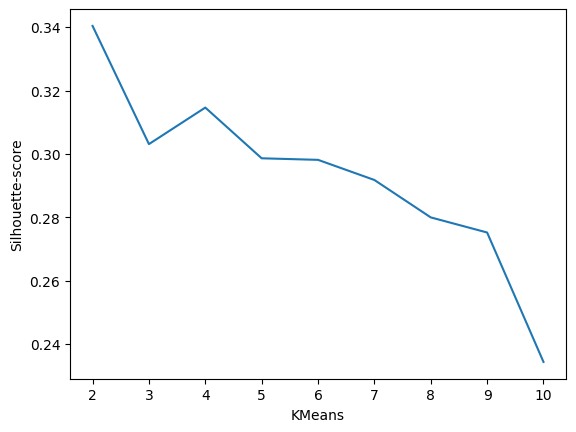

Best silhouette is obtained with k as:  2


C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1,cluster
0,0.611226,0.331334,1
1,0.420234,0.326435,1
2,0.120909,0.567999,0
3,0.241267,0.600119,0
4,0.130502,0.688136,0
...,...,...,...
16341,0.182792,0.623920,0
16342,0.501244,0.790000,0
16343,0.373051,0.661360,0
16344,0.675174,0.392907,1


In [1013]:
pal.clusterV2()

In [1014]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('Cluster-label', ClusterIdentifier(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [1015]:
pal.output

,0,1,cluster
0,0.611226,0.331334,1
1,0.420234,0.326435,1
2,0.120909,0.567999,0
3,0.241267,0.600119,0
4,0.130502,0.688136,0
...,...,...,...
16341,0.182792,0.623920,0
16342,0.501244,0.790000,0
16343,0.373051,0.661360,0
16344,0.675174,0.392907,1


In [1016]:
pal.test_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,245800.0
16383,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,137900.0
7731,-118.14,33.92,31.0,3731.0,853.0,2313.0,801.0,3.2237,218200.0
1410,-122.07,37.94,30.0,1260.0,276.0,707.0,221.0,2.8920,220800.0
1335,-121.89,37.99,4.0,2171.0,597.0,928.0,461.0,4.1016,170500.0
...,...,...,...,...,...,...,...,...,...
8291,-118.15,33.76,36.0,2916.0,785.0,1183.0,749.0,3.5985,500001.0
6274,-117.95,34.03,33.0,1782.0,394.0,1517.0,376.0,3.3389,157900.0
2997,-119.03,35.32,12.0,2721.0,549.0,1294.0,523.0,2.5575,100200.0
13440,-117.42,34.08,28.0,2300.0,419.0,1312.0,444.0,3.4844,127700.0


In [1017]:
pal.execute_pipeline()

array([[-1.17240000e+02,  3.27900000e+01,  2.00000000e+01, ...,
         9.57229041e+04,  1.21202137e+05,  0.00000000e+00],
       [-1.21290000e+02,  3.80100000e+01,  2.00000000e+00, ...,
         1.29698352e+04,  2.29114866e+05,  0.00000000e+00],
       [-1.18140000e+02,  3.39200000e+01,  3.10000000e+01, ...,
         6.81244257e+04,  1.48785922e+05,  0.00000000e+00],
       ...,
       [-1.19030000e+02,  3.53200000e+01,  1.20000000e+01, ...,
         4.98949865e+04,  2.66780914e+05,  0.00000000e+00],
       [-1.17420000e+02,  3.40800000e+01,  2.80000000e+01, ...,
         2.23955417e+04,  2.39281937e+05,  0.00000000e+00],
       [-1.17100000e+02,  3.25700000e+01,  1.40000000e+01, ...,
         1.67760433e+04,  2.33302927e+05,  0.00000000e+00]])

In [1018]:
pal.output

,0,1,cluster
0,0.611226,0.331334,1
1,0.420234,0.326435,1
2,0.120909,0.567999,0
3,0.241267,0.600119,0
4,0.130502,0.688136,0
...,...,...,...
16341,0.182792,0.623920,0
16342,0.501244,0.790000,0
16343,0.373051,0.661360,0
16344,0.675174,0.392907,1


In [1019]:
pal.transformed_test

array([[-1.17240000e+02,  3.27900000e+01,  2.00000000e+01, ...,
         9.57229041e+04,  1.21202137e+05,  0.00000000e+00],
       [-1.21290000e+02,  3.80100000e+01,  2.00000000e+00, ...,
         1.29698352e+04,  2.29114866e+05,  0.00000000e+00],
       [-1.18140000e+02,  3.39200000e+01,  3.10000000e+01, ...,
         6.81244257e+04,  1.48785922e+05,  0.00000000e+00],
       ...,
       [-1.19030000e+02,  3.53200000e+01,  1.20000000e+01, ...,
         4.98949865e+04,  2.66780914e+05,  0.00000000e+00],
       [-1.17420000e+02,  3.40800000e+01,  2.80000000e+01, ...,
         2.23955417e+04,  2.39281937e+05,  0.00000000e+00],
       [-1.17100000e+02,  3.25700000e+01,  1.40000000e+01, ...,
         1.67760433e+04,  2.33302927e+05,  0.00000000e+00]])

In [344]:
pal.execute_pipeline()

array([[0.53187251, 0.47058824, 0.03822677, ..., 0.0588719 , 0.08146784,
        0.06742446],
       [0.48705179, 0.56862745, 0.07480035, ..., 0.09587239, 0.14009462,
        0.06350695],
       [0.19023904, 1.        , 0.09735999, ..., 0.15819766, 0.2055282 ,
        1.        ],
       ...,
       [0.22908367, 0.47058824, 0.10450684, ..., 0.09324124, 0.60205376,
        1.        ],
       [0.45717131, 0.68627451, 0.06371128, ..., 0.07778326, 0.15759093,
        0.1181459 ],
       [0.59561753, 0.31372549, 0.04539905, ..., 0.07350765, 0.21049365,
        0.2814442 ]])

In [351]:
pal.test_X

,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
15362,-117.22,16.0,3165.0,482.0,1351.0,452.0,4.6050,263300.0,<1H OCEAN
16623,-120.83,28.0,4323.0,886.0,1650.0,705.0,2.7266,266800.0,NEAR OCEAN
18086,-122.05,25.0,4111.0,538.0,1585.0,568.0,9.2298,500001.0,<1H OCEAN
2144,-119.76,36.0,2507.0,466.0,1227.0,474.0,2.7850,72300.0,INLAND


In [352]:
pal.transformed_test

array([[0.53187251, 0.47058824, 0.03822677, ..., 0.0588719 , 0.08146784,
        0.06742446],
       [0.48705179, 0.56862745, 0.07480035, ..., 0.09587239, 0.14009462,
        0.06350695],
       [0.19023904, 1.        , 0.09735999, ..., 0.15819766, 0.2055282 ,
        1.        ],
       ...,
       [0.22908367, 0.47058824, 0.10450684, ..., 0.09324124, 0.60205376,
        1.        ],
       [0.45717131, 0.68627451, 0.06371128, ..., 0.07778326, 0.15759093,
        0.1181459 ],
       [0.59561753, 0.31372549, 0.04539905, ..., 0.07350765, 0.21049365,
        0.2814442 ]])

In [323]:
pal.execute_pipeline()

array([[0.53187251, 0.37340426, 0.47058824, ..., 0.0588719 , 0.08146784,
        0.06742446],
       [0.48705179, 0.27553191, 0.56862745, ..., 0.09587239, 0.14009462,
        0.06350695],
       [0.19023904, 0.55851064, 1.        , ..., 0.15819766, 0.2055282 ,
        1.        ],
       ...,
       [0.22908367, 0.50638298, 0.47058824, ..., 0.09324124, 0.60205376,
        1.        ],
       [0.45717131, 0.44893617, 0.68627451, ..., 0.07778326, 0.15759093,
        0.1181459 ],
       [0.59561753, 0.17765957, 0.31372549, ..., 0.07350765, 0.21049365,
        0.2814442 ]])

In [299]:
pal.transformed_testset

array([[0.53902185, 0.37971953, 0.47058824, ..., 0.06882591, 0.08146784,
        0.06742446],
       [0.49219563, 0.28047465, 0.56862745, ..., 0.11220359, 0.14009462,
        0.06350695],
       [0.18210198, 0.56742179, 1.        , ..., 0.18527087, 0.2055282 ,
        1.        ],
       ...,
       [0.2226847 , 0.51456311, 0.47058824, ..., 0.10911895, 0.60205376,
        1.        ],
       [0.46097815, 0.45631068, 0.68627451, ..., 0.09099672, 0.15759093,
        0.1181459 ],
       [0.60561915, 0.18122977, 0.31372549, ..., 0.08598419, 0.21049365,
        0.2814442 ]])

In [200]:
pal.current_version

3

In [201]:
pal.transformation_history[-1]

{'version': 3,
 'transformation': 'Encoded order of categorial features',
 'result':        longitude  housing_median_age  total_rooms  total_bedrooms  population  \
 0       0.211155            0.784314     0.022331        0.019863    0.008941   
 1       0.212151            0.392157     0.180503        0.171477    0.067210   
 2       0.210159            1.000000     0.037260        0.029330    0.013818   
 3       0.209163            1.000000     0.032352        0.036313    0.015555   
 4       0.209163            1.000000     0.041330        0.043296    0.015752   
 ...          ...                 ...          ...             ...         ...   
 20635   0.324701            0.470588     0.042296        0.057883    0.023599   
 20636   0.312749            0.333333     0.017676        0.023122    0.009894   
 20637   0.311753            0.313725     0.057277        0.075109    0.028140   
 20638   0.301793            0.333333     0.047256        0.063315    0.020684   
 20639   0.309

In [84]:
pal.random_split()

(       latitude  housing_median_age  total_rooms  total_bedrooms  population  \
 16490     38.00                27.0       1683.0           288.0       873.0   
 6090      34.10                15.0       6409.0          1363.0      3359.0   
 10973     33.76                26.0       2312.0           525.0      1273.0   
 17287     34.35                34.0       1664.0           292.0       705.0   
 12615     38.50                25.0       4719.0           745.0      1857.0   
 ...         ...                 ...          ...             ...         ...   
 5606      33.79                16.0       1867.0           571.0       951.0   
 16339     38.04                16.0       3295.0           565.0      2279.0   
 14965     32.74                18.0       3341.0           611.0      1952.0   
 11117     33.84                16.0       1545.0           354.0       730.0   
 8472      33.91                35.0        940.0           197.0       640.0   
 
        households  median

In [151]:
pal.train_Y

,longitude
14196,-117.03
8267,-118.16
17445,-120.48
14265,-117.11
2271,-119.80
...,...
11284,-117.96
11964,-117.43
5390,-118.38
860,-121.96


In [190]:
pal.transformation_history[0].get('pipeline')

ColumnTransformer(transformers=[])

In [191]:
pal.scale(strategy="MinMax")

array([[0.21115538, 0.78431373, 0.02233074, ..., 0.02055583, 0.53966842,
        0.90226638],
       [0.21215139, 0.39215686, 0.18050257, ..., 0.18697583, 0.53802706,
        0.70824656],
       [0.21015936, 1.        , 0.03726029, ..., 0.02894261, 0.46602805,
        0.69505074],
       ...,
       [0.31175299, 0.31372549, 0.05727657, ..., 0.07104095, 0.08276438,
        0.15938285],
       [0.30179283, 0.33333333, 0.04725571, ..., 0.05722743, 0.09429525,
        0.14371281],
       [0.30976096, 0.29411765, 0.07078183, ..., 0.08699227, 0.13025338,
        0.15340349]])

In [192]:
pal.current_version

2

In [193]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [53]:
pal.fill_nulls()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14196,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445
8267,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906
17445,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949
14265,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651
2271,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043
...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650
11964,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723
5390,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011
860,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608


In [54]:
pal.current_version

2

In [55]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [198]:
pal.encode_order()

,ocean_proximity
0,3.0
1,3.0
2,3.0
3,3.0
4,3.0
...,...
20635,1.0
20636,1.0
20637,1.0
20638,1.0


In [199]:
pal.PCA()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [57]:
pal.current_version

3

In [58]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('pca', PCA(n_components=0.8),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [59]:
pal.restore()

In [60]:
pal.current_version

2

In [61]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value'])])

In [64]:
pal.encode_order()

""
14196
8267
17445
14265
2271
...
11284
11964
5390
860


C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

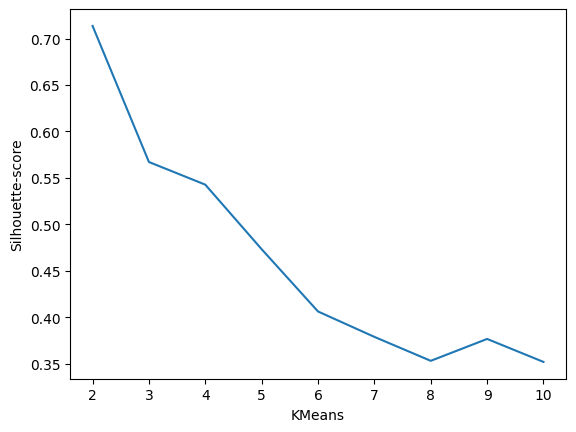

Best silhouette is obtained with k as:  2


C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Cluster
14196,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445,4.0,Cluster 1
8267,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906,4.0,Cluster 1
17445,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949,4.0,Cluster 1
14265,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651,4.0,Cluster 1
2271,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043,1.0,Cluster 0
...,...,...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650,0.0,Cluster 0
11964,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723,1.0,Cluster 0
5390,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011,0.0,Cluster 0
860,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608,0.0,Cluster 0


In [65]:
pal.cluster()

In [66]:
pal.encode_order(include_features=['Cluster'])

,Cluster
14196,1.0
8267,1.0
17445,1.0
14265,1.0
2271,0.0
...,...
11284,0.0
11964,0.0
5390,0.0
860,0.0


In [67]:
pal.output

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,Cluster
14196,0.729084,0.017021,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445,4.0,1.0
8267,0.616534,0.129787,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906,4.0,1.0
17445,0.385458,0.224468,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949,4.0,1.0
14265,0.721116,0.014894,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651,4.0,1.0
2271,0.453187,0.450000,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650,0.0,0.0
11964,0.689243,0.156383,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723,1.0,0.0
5390,0.594622,0.157447,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011,0.0,0.0
860,0.238048,0.535106,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608,0.0,0.0


In [70]:
pal.current_version

6

In [71]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('impute', SimpleImputer(strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value']),
                                ('ordinal', OrdinalEncoder(),
                                 ['ocean_proximity']),
                                ('ordinal', OrdinalEncoder(), []),
                                (None, None, None),
                                ('ordinal', OrdinalEncoder(), ['Cluster'])])

In [140]:
pal.restore(version=3)

In [141]:
pal.current_version

3

In [142]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(transformers=['scaler', MinMaxScaler(),
                                ['longitude', 'latitude'], 'impute',
                                SimpleImputer(strategy='median'),
                                ['longitude', 'latitude'], 'pca',
                                PCA(n_components=0.8), ['median_income']])

In [ ]:
X = df.drop(columns=['ocean_proximity'])
Y = df['ocean_proximity']

In [28]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=0.20, random_state=42)

In [33]:
len(test_X)

4128

In [202]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.cluster import KMeans

class BestKColumnAdder(BaseEstimator,TransformerMixin):
    def __init__(self, best_K=None):
        self.best_K = best_K
    def fit(self, X,y=None):
        return self
    def transform(self, X):
        X['Cluster'] = ["Cluster " + str(i) for i in KMeans(n_clusters=6, random_state=42).predict(X)]

In [370]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)
df_train = df.iloc[0:15000,]
df_test = df.iloc[15000:,]

In [371]:
transformer = BestKColumnAdder(best_K=6)
transformer

BestKColumnAdder(best_K=6)

In [372]:
fitted = transformer.fit(df_train)

In [214]:
#df_train.head()
#df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15000,-117.04,32.74,33.0,3880.0,770.0,2288.0,805.0,3.6848,140700.0,NEAR OCEAN
15001,-117.02,32.74,12.0,3301.0,963.0,2000.0,879.0,1.8594,119200.0,NEAR OCEAN
15002,-117.04,32.74,5.0,2878.0,785.0,1727.0,758.0,1.7179,132000.0,NEAR OCEAN
15003,-117.04,32.75,36.0,2297.0,418.0,1070.0,392.0,3.5192,144000.0,NEAR OCEAN
15004,-117.05,32.75,29.0,2767.0,612.0,1437.0,587.0,2.8306,142900.0,NEAR OCEAN


______

In [417]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)
df_train = df.select_dtypes(include='float').dropna().iloc[0:15000,]
df_test = df.select_dtypes(include='float').dropna().iloc[15000:,]

In [418]:
fittedKM = KMeans(n_clusters=3).fit(df_train)
fittedKM

C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [419]:
#fittedKM.predict(df_train)
#fittedKM.predict(df_test)

In [422]:
test_clusters = fittedKM.transform(df_test)
test_clusters

array([[ 95882.85689222, 207704.51419933,  15908.28514534],
       [ 73176.80190226, 230403.53532639,  38584.46897614],
       [  3663.28061751, 300311.29870418, 108503.53372654],
       ...,
       [ 23731.45285155, 327304.43411854, 135485.72430835],
       [ 31339.54825592, 334905.98037107, 143089.0921146 ],
       [ 26630.59098654, 330203.42867305, 138383.53318064]])

In [425]:
test_trans = pd.DataFrame(data=test_clusters).apply(lambda x: x.astype(float))
test_trans['cluster_transform'] = test_trans.idxmin(axis='columns')
test_trans['cluster_predict'] = [i for i in fittedKM.predict(df_test)]
test_trans[['cluster_transform','cluster_predict']]

,cluster_transform,cluster_predict
0,2,2
1,2,2
2,0,0
3,2,2
4,1,1
...,...,...
5428,0,0
5429,0,0
5430,0,0
5431,0,0


In [564]:
    def clusterV2(self, max_k=10, store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        dataset = self.output
        from sklearn.cluster import KMeans
        from matplotlib import pyplot
        from sklearn.metrics import silhouette_score
        kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        if store:
            bestKMeans = KMeans(n_clusters=best_k, random_state=42).fit(dataset)
            self.output["Cluster"] = ["Cluster " + str(i) for i in bestKMeans.predict(dataset)]
            self.update_attributes()
            self.update_history(step="Added Cluster-label as column to dataset",snapshot=self.output)
        return self.output

In [660]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.cluster import KMeans
from sklearn.utils import check_random_state

class ClusterIdentifier(BaseEstimator,TransformerMixin):
    def __init__(self, best_K=None,random_state=None):
        self.random_state = random_state
        self.best_K = best_K

    def fit(self, X, y=None):
        self.random_state_ = check_random_state(self.random_state)
        self.estimator = KMeans(n_clusters=self.best_K,random_state=42).fit(X)
        return self

    def transform(self, X, y=None):
        X_trans = pd.DataFrame(data=self.estimator.transform(X)).apply(lambda x: x.astype(float))
        X_trans['cluster'] = X_trans.idxmin(axis=1)
        return X_trans

In [661]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)
df_train = df.select_dtypes(include='float').dropna().iloc[0:15000,]
df_test = df.select_dtypes(include='float').dropna().iloc[15000:,]

TEST_Fit = ClusterIdentifier(best_K=3).fit(X=df_train)

C:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [662]:
TEST_Trans = TEST_Fit.transform(df_train)

In [663]:
TEST_Trans

,0,1,2,cluster
0,224634.177420,32998.218389,336468.298539,1
1,130596.521745,61341.775715,242412.401431,1
2,124134.516296,67619.468016,235966.776686,1
3,113337.443763,78419.221478,225167.459715,1
4,114232.722524,77511.707767,226065.888969,1
...,...,...,...,...
14995,81092.830749,272797.831977,30827.966390,2
14996,57886.729032,249596.530865,53965.506135,2
14997,41478.950217,233194.085234,70366.035006,0
14998,609.054861,191894.938664,111663.601100,0


Det har noget med antallet af kolonner der kommer med fra transformation til transformation når Execute_pipeline afvikles. Undersøg passthrough.
OPDATERING: Det skyldes at ColumnTransformer ikke er designet til at lave multiple transformationer på samme kolonne.
MULIG LØSNING: Udtræk alene de sets() som udgør ColumnTransformers argumenter og grupper dem så efter kolonner ind til nye Pipelines


In [1125]:
transSteps = [('første',SimpleImputer(),['colA','colB']),('anden',MinMaxScaler(),['colA','colB','colC'])]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin



dict1 = dict(version=0,transformation='input',result='data',transformer=SimpleImputer(),cols=['A','B','C'])
dict2 = dict(version=0,transformation='scaler',result='data',transformer=StandardScaler(),cols=['B','C','D'])
myList = [dict1, dict2]
myList

[{'version': 0,
  'transformation': 'input',
  'result': 'data',
  'transformer': SimpleImputer(),
  'cols': ['A', 'B', 'C']},
 {'version': 0,
  'transformation': 'scaler',
  'result': 'data',
  'transformer': StandardScaler(),
  'cols': ['B', 'C', 'D']}]

In [6]:
import itertools

pipelines = [i.get('transformer') for i in myList]
cols = [i.get('cols') for i in myList]
unique_cols = set([i for j in cols for i in j])

zipped_pairs = ((c,[p]) for c,p in zip(cols,pipelines))
cross_combination = [element for pair in zipped_pairs for element in itertools.product(*pair)]
cross_combination

[('A', SimpleImputer()),
 ('B', SimpleImputer()),
 ('C', SimpleImputer()),
 ('B', StandardScaler()),
 ('C', StandardScaler()),
 ('D', StandardScaler())]

In [100]:
dct={}

for key,value in cross_combination:
    if key not in dct:
        dct[key]=[value]
    else:
        dct[key]+=[value]
dct

{'A': [SimpleImputer()],
 'B': [SimpleImputer(), StandardScaler()],
 'C': [SimpleImputer(), StandardScaler()],
 'D': [StandardScaler()]}

In [123]:
myList = [(k,v) for k,v in dct.items()]

test = itertools.groupby(myList,lambda x:x[1])

for k,v in test:
    print([item for item in v])

[('A', [SimpleImputer()])]
[('B', [SimpleImputer(), StandardScaler()]), ('C', [SimpleImputer(), StandardScaler()])]
[('D', [StandardScaler()])]


In [162]:
myList = [(k,v) for k,v in dct.items()]

test = itertools.groupby(myList,lambda x:x[1])

for key,group in test:
    print(list([elem for item in tup[0] for elem in item] for tup in group))

[['A']]
[['B'], ['C']]
[['D']]


In [203]:
myList = [(k,v) for k,v in dct.items()]

for key,group in itertools.groupby(myList,lambda x:x[1]):
    print(list(item[0] for tup in group for item in tup[0]))

['A']
['B', 'C']
['D']


In [210]:
myList = [(k,v) for k,v in dct.items()]

finalList = []

for key,group in itertools.groupby(myList,lambda x:x[1]):
    finalList.append((key,list(item[0] for tup in group for item in tup[0])))

In [211]:
finalList

[([SimpleImputer()], ['A']),
 ([SimpleImputer(), StandardScaler()], ['B', 'C']),
 ([StandardScaler()], ['D'])]